<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.8 MB/s eta 0:00:00


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos

In [4]:
import os
from PyPDF2 import PdfReader

# Ruta del archivo PDF
pdf_path = 'Economia comestible - HaJoon Chang.pdf'

# Muestra el directorio de trabajo actual
print("Directorio de trabajo:", os.getcwd())

# Verifica si el archivo existe
if os.path.exists(pdf_path):
    print(f"El archivo {pdf_path} existe.")
else:
    print(f"El archivo {pdf_path} no existe.")
    exit()

# Intenta abrir el archivo PDF con PyPDF2
try:
    with open(pdf_path, "rb") as file:
        reader = PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()  # Extrae el texto de cada página
except Exception as e:
    print(f"Error al abrir el archivo PDF con PyPDF2: {e}")
    exit()


# Convierte el texto en una lista de palabras
texto_extraido = text.split()  # Divide el texto en palabras usando los espacios

# Muestra la lista de palabras extraídas
print("Palabras extraídas:")
print(texto_extraido)


Directorio de trabajo: /content
El archivo Economia comestible - HaJoon Chang.pdf existe.
Palabras extraídas:
['Cuando,', 'en', 'los', 'años', 'ochenta,', 'el', 'economista', 'Ha-Joon', 'Chang', 'aterrizó', 'por', 'primera', 'vez', 'en', 'Reino', 'Unido', 'desde', 'Corea', 'del', 'Sur,', 'se', 'encontró', 'con', 'un', 'país', 'que', 'comenzaba', 'a', 'salir', 'de', 'la', 'insípida', 'dieta', 'inglesa', 'y', 'a', 'experimentar', 'con', 'los', 'sabores', 'del', 'resto', 'del', 'mundo.', 'Era', 'un', 'trayecto', 'inverso', 'al', 'que', 'estaba', 'recorriendo', 'la', 'economía,', 'cada', 'vez', 'más', 'acomodada', 'en', 'una', 'única', 'escuela.', 'Su', 'nuevo', 'y', 'esperado', 'libro,', 'Economía', 'comestible', ',', 'demuestra', 'con', 'ejemplos', 'claros', 'y', 'sabrosos', 'que', 'del', 'mismo', 'modo', 'que', 'es', 'esencial', 'abrirse', 'a', 'las', 'diversas', 'tradiciones', 'culinarias', 'también', 'lo', 'es', 'disponer', 'de', 'una', 'amplia', 'variedad', 'de', 'perspectivas', 'eco

Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



### Elegir el tamaño del contexto

In [5]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [6]:
import nltk

# Download the required 'punkt_tab' resource
nltk.download('punkt_tab')

# Ensure 'punkt' is also downloaded, which is often a dependency
nltk.download('punkt')

# Segmentamos el texto en oraciones
sentences = nltk.sent_tokenize(text)  # Usamos NLTK para dividir el texto en oraciones

# Aplicamos 'text_to_word_sequence' para cada oración segmentada
segmented_sentences = [text_to_word_sequence(sentence) for sentence in sentences]

# Muestra las oraciones segmentadas y tokenizadas
print(segmented_sentences)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[['cuando', 'en', 'los', 'años', 'ochenta', 'el', 'economista', 'ha', 'joon', 'chang', 'aterrizó', 'por', 'primera', 'vez', 'en', 'reino', 'unido', 'desde', 'corea', 'del', 'sur', 'se', 'encontró', 'con', 'un', 'país', 'que', 'comenzaba', 'a', 'salir', 'de', 'la', 'insípida', 'dieta', 'inglesa', 'y', 'a', 'experimentar', 'con', 'los', 'sabores', 'del', 'resto', 'del', 'mundo'], ['era', 'un', 'trayecto', 'inverso', 'al', 'que', 'estaba', 'recorriendo', 'la', 'economía', 'cada', 'vez', 'más', 'acomodada', 'en', 'una', 'única', 'escuela'], ['su', 'nuevo', 'y', 'esperado', 'libro', 'economía', 'comestible', 'demuestra', 'con', 'ejemplos', 'claros', 'y', 'sabrosos', 'que', 'del', 'mismo', 'modo', 'que', 'es', 'esencial', 'abrirse', 'a', 'las', 'diversas', 'tradiciones', 'culinarias', 'también', 'lo', 'es', 'disponer', 'de', 'una', 'amplia', 'variedad', 'de', 'perspectivas', 'económicas'], ['en', 'este', 'fascinante', 'y', 'delicioso', 'volumen', 'chang', 'convierte', 'en', 'apetecibles', 't

In [7]:
text[0]

'C'

In [8]:
segmented_sentences[0]

['cuando',
 'en',
 'los',
 'años',
 'ochenta',
 'el',
 'economista',
 'ha',
 'joon',
 'chang',
 'aterrizó',
 'por',
 'primera',
 'vez',
 'en',
 'reino',
 'unido',
 'desde',
 'corea',
 'del',
 'sur',
 'se',
 'encontró',
 'con',
 'un',
 'país',
 'que',
 'comenzaba',
 'a',
 'salir',
 'de',
 'la',
 'insípida',
 'dieta',
 'inglesa',
 'y',
 'a',
 'experimentar',
 'con',
 'los',
 'sabores',
 'del',
 'resto',
 'del',
 'mundo']

In [9]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([193., 305., 437., 379., 367., 238., 225., 117.,  80.,  47.,  27.,
         19.,  10.,   4.,   2.,   2.,   5.,   0.,   0.,   1.]),
 array([  1.  ,   7.45,  13.9 ,  20.35,  26.8 ,  33.25,  39.7 ,  46.15,
         52.6 ,  59.05,  65.5 ,  71.95,  78.4 ,  84.85,  91.3 ,  97.75,
        104.2 , 110.65, 117.1 , 123.55, 130.  ]),
 <BarContainer object of 20 artists>)

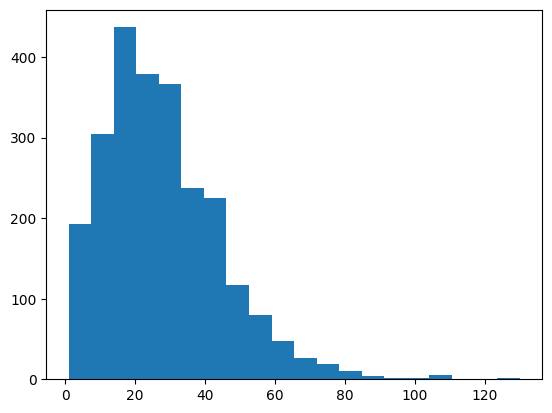

In [10]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [11]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 49


###  Tokenizar

In [12]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [13]:
tokenized_sentences[0]

[35,
 3,
 7,
 63,
 515,
 5,
 938,
 40,
 1460,
 277,
 4852,
 15,
 156,
 57,
 3,
 482,
 449,
 83,
 62,
 11,
 126,
 10,
 1234,
 14,
 13,
 45,
 4,
 4853,
 8,
 3109,
 1,
 2,
 3110,
 817,
 560,
 6,
 8,
 4854,
 14,
 7,
 1090,
 11,
 450,
 11,
 44]

In [14]:
segmented_sentences[0]

['cuando',
 'en',
 'los',
 'años',
 'ochenta',
 'el',
 'economista',
 'ha',
 'joon',
 'chang',
 'aterrizó',
 'por',
 'primera',
 'vez',
 'en',
 'reino',
 'unido',
 'desde',
 'corea',
 'del',
 'sur',
 'se',
 'encontró',
 'con',
 'un',
 'país',
 'que',
 'comenzaba',
 'a',
 'salir',
 'de',
 'la',
 'insípida',
 'dieta',
 'inglesa',
 'y',
 'a',
 'experimentar',
 'con',
 'los',
 'sabores',
 'del',
 'resto',
 'del',
 'mundo']

In [15]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

11573

Al ser un vocabulario muy grande y esto traer problemas de GPU, reduzo el tamaño de este para quedarme con las palabras mas frecuentes

In [16]:
from collections import Counter

# Cuenta la frecuencia de todas las palabras en los textos tokenizados
word_freq = Counter([word for sentence in tokenized_sentences for word in sentence])

# Define un umbral de frecuencia (e.g., palabras que aparecen menos de 5 veces)
min_freq = 6
reduced_vocab = {word for word, freq in word_freq.items() if freq >= min_freq}

# Crear un nuevo tokenizador con el vocabulario reducido
reduced_vocab_size = len(reduced_vocab)
word_to_index = {word: i+1 for i, word in enumerate(reduced_vocab)}  # Mapear palabras a índices
index_to_word = {i: word for word, i in word_to_index.items()}  # Inverso para decodificar

# Tokeniza las oraciones de nuevo usando solo el vocabulario reducido
tokenized_sentences_reduced = [[word_to_index[word] for word in sentence if word in reduced_vocab]
                               for sentence in tokenized_sentences]


In [17]:
print("Tamaño del vocabulario:", len(word_to_index))

Tamaño del vocabulario: 1459


In [18]:
# Definir el límite del vocabulario
max_vocab_size = 1000

# Obtener las `max_vocab_size` palabras más comunes
most_common_words = word_freq.most_common(max_vocab_size)
reduced_vocab = {word for word, freq in most_common_words}

# Crear el nuevo diccionario de índices
word_to_index = {word: i+1 for i, word in enumerate(reduced_vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Tokenizar nuevamente con el vocabulario reducido
tokenized_sentences_reduced = [[word_to_index[word] for word in sentence if word in reduced_vocab]
                               for sentence in tokenized_sentences]

In [19]:
print("Tamaño del vocabulario reducido:", len(word_to_index))

Tamaño del vocabulario reducido: 1000


### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [20]:
tokenized_sentences_train, tokenized_sentences_val  = train_test_split(tokenized_sentences_reduced, test_size=0.2, random_state=42)

In [21]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [22]:
len(tok_sent)

2403

In [23]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [24]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [25]:
train_seqs.shape

(58037, 50)

In [26]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [27]:
y.shape

(58037, 49)

In [28]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'en',
 4: 'que',
 5: 'el',
 6: 'y',
 7: 'los',
 8: 'a',
 9: 'las',
 10: 'se',
 11: 'del',
 12: 'no',
 13: 'un',
 14: 'con',
 15: 'por',
 16: 'una',
 17: 'para',
 18: 'más',
 19: 'es',
 20: 'como',
 21: 'página',
 22: 'lo',
 23: 'su',
 24: 'al',
 25: 'o',
 26: 'pero',
 27: 'sus',
 28: '\u202f',
 29: 'países',
 30: 'también',
 31: 'era',
 32: 'me',
 33: 'solo',
 34: 'sobre',
 35: 'cuando',
 36: 'the',
 37: 'son',
 38: 'si',
 39: 'hasta',
 40: 'ha',
 41: 'véase',
 42: 'economía',
 43: 'todo',
 44: 'mundo',
 45: 'país',
 46: 'ya',
 47: 'ese',
 48: 'entre',
 49: 'sin',
 50: 'este',
 51: 'gran',
 52: 'mi',
 53: 'muy',
 54: 'forma',
 55: 'durante',
 56: 'menos',
 57: 'vez',
 58: 'fue',
 59: 'personas',
 60: 'aunque',
 61: 'porque',
 62: 'corea',
 63: 'años',
 64: 'of',
 65: 'estados',
 66: 'incluso',
 67: 'mayor',
 68: 'todos',
 69: 'han',
 70: 'siglo',
 71: 'puede',
 72: 'unidos',
 73: 'mayoría',
 74: 'parte',
 75: 'otras',
 76: 'muchos',
 77: 'así',
 78: 'eso',
 79: 

In [29]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

11573

In [30]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'en': 3, 'que': 4, 'el': 5, 'y': 6, 'los': 7, 'a': 8, 'las': 9, 'se': 10, 'del': 11, 'no': 12, 'un': 13, 'con': 14, 'por': 15, 'una': 16, 'para': 17, 'más': 18, 'es': 19, 'como': 20, 'página': 21, 'lo': 22, 'su': 23, 'al': 24, 'o': 25, 'pero': 26, 'sus': 27, '\u202f': 28, 'países': 29, 'también': 30, 'era': 31, 'me': 32, 'solo': 33, 'sobre': 34, 'cuando': 35, 'the': 36, 'son': 37, 'si': 38, 'hasta': 39, 'ha': 40, 'véase': 41, 'economía': 42, 'todo': 43, 'mundo': 44, 'país': 45, 'ya': 46, 'ese': 47, 'entre': 48, 'sin': 49, 'este': 50, 'gran': 51, 'mi': 52, 'muy': 53, 'forma': 54, 'durante': 55, 'menos': 56, 'vez': 57, 'fue': 58, 'personas': 59, 'aunque': 60, 'porque': 61, 'corea': 62, 'años': 63, 'of': 64, 'estados': 65, 'incluso': 66, 'mayor': 67, 'todos': 68, 'han': 69, 'siglo': 70, 'puede': 71, 'unidos': 72, 'mayoría': 73, 'parte': 74, 'otras': 75, 'muchos': 76, 'así': 77, 'eso': 78, 'otros': 79, 'desarrollo': 80, 'tan': 81, 'e': 82, 'desde': 83, 'esos': 84, 'ser':

In [31]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'la': 1302, 'insípida': 2, 'que': 1152, 'un': 501, 'inglesa': 13, 'y': 1097, 'sabores': 7, 'economista': 8, 'de': 1770, 'sur': 45, 'cuando': 137, 'el': 1037, 'por': 449, 'se': 693, 'comenzaba': 1, 'mundo': 109, 'dieta': 9, 'vez': 85, 'encontró': 6, 'aterrizó': 1, 'unido': 16, 'los': 920, 'en': 1258, 'desde': 64, 'país': 106, 'resto': 16, 'salir': 2, 'años': 77, 'reino': 15, 'a': 952, 'primera': 40, 'con': 465, 'del': 596, 'experimentar': 1, 'chang': 22, 'corea': 78, 'ha': 110, 'joon': 4, 'ochenta': 14, 'trayecto': 2, 'cada': 31, 'más': 427, 'escuela': 13, 'una': 443, 'inverso': 1, 'estaba': 21, 'recorriendo': 1, 'única': 7, 'al': 273, 'acomodada': 1, 'era': 146, 'economía': 108, 'perspectivas': 4, 'mismo': 54, 'comestible': 3, 'claros': 1, 'es': 422, 'disponer': 3, 'ejemplos': 11, 'demuestra': 11, 'culinarias': 6, 'esencial': 8, 'sabrosos': 2, 'diversas': 6, 'también': 183, 'amplia': 3, 'las': 639, 'nuevo': 9, 'su': 278, 'abrirse': 1, 'económicas': 27, 'espe


### Definir el modelo

In [32]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=max_vocab_size+1, output_dim=32, input_shape=(None,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(max_vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 32)            │          32,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 1001)          │          65,065 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,953 (605.29 KB)

 Trainable params: 154,953 (605.29 KB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [33]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [34]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=30, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/30
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6028 - loss: 3.5665


 mean perplexity: 839.670336194627 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.6033 - loss: 3.5499
Epoch 2/30
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6526 - loss: 2.0644


 mean perplexity: 815.2099628048139 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.6526 - loss: 2.0642
Epoch 3/30
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6540 - loss: 2.0407


 mean perplexity: 729.0600660347794 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6540 - loss: 2.0407
Epoch 4/30
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6535 - loss: 2.0346


 mean perplexity: 709.8155798154247 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6535 - loss: 2.0345
Epoch 5/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6573 - loss: 1.9989


 mean perplexity: 662.1022848607008 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6573 - loss: 1.9988
Epoch 6/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6662 - loss: 1.9427


 mean perplexity: 616.2838046326461 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6662 - loss: 1.9426
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6672 - loss: 1.9171


 mean perplexity: 606.0990803471917 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6672 - loss: 1.9171
Epoch 8/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6694 - loss: 1.8913


 mean perplexity: 592.9519210274966 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6694 - loss: 1.8912
Epoch 9/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6745 - loss: 1.8582
 mean perplexity: 594.5314792057329 

227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6745 - loss: 1.8582
Epoch 10/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6770 - loss: 1.8336


 mean perplexity: 573.9943931978008 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6770 - loss: 1.8336
Epoch 11/30
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6790 - loss: 1.8111


 mean perplexity: 560.7451594535236 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6790 - loss: 1.8110
Epoch 12/30
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6794 - loss: 1.7988
 mean perplexity: 573.810542882378 

227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6794 - loss: 1.7987
Epoch 13/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6824 - loss: 1.7705


 mean perplexity: 558.4840847838965 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6824 - loss: 1.7705
Epoch 14/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6827 - loss: 1.7579


 mean perplexity: 550.1736789511389 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6827 - loss: 1.7579
Epoch 15/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6824 - loss: 1.7471


 mean perplexity: 525.1465437857121 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6824 - loss: 1.7470
Epoch 16/30
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6848 - loss: 1.7259


 mean perplexity: 510.05570535167743 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6848 - loss: 1.7258
Epoch 17/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6889 - loss: 1.6988
 mean perplexity: 529.8474764880714 

227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6889 - loss: 1.6988
Epoch 18/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6900 - loss: 1.6857
 mean perplexity: 515.5929369786122 

227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6900 - loss: 1.6857
Epoch 19/30
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6916 - loss: 1.6709


 mean perplexity: 499.0169489634588 

Saved new model!
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6916 - loss: 1.6707
Epoch 20/30
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6969 - loss: 1.6403
 mean perplexity: 503.2791301888897 

227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6968 - loss: 1.6404
Epoch 21/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6969 - loss: 1.6335
 mean perplexity: 504.5799717234369 

227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6969 - loss: 1.6334
Epoch 22/30
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7004 - loss: 1.6141
 mean perplexity: 500.1614106410916 

227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7004 - loss: 1.6141
Epoch 23/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7029 - loss: 1.5953
 mean perplexity: 499.58530586748503 

227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7029 - loss: 1.5953
Epoch 24/30
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - 

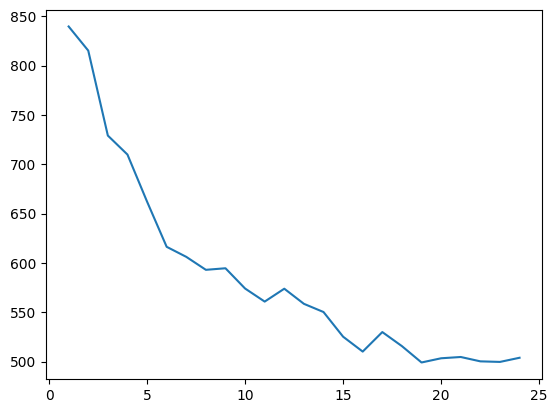

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [36]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


### Predicción de próxima palabra

In [37]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.3 MB/s eta 0:00:00


In [38]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0e89a36a372e588fd5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0e89a36a372e588fd5.gradio.live


### Generación de secuencias

In [39]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [40]:
input_texts = ['capacidad de desarrollar tecnologías', 'información se desarrollaron', 'tuviera cierto sentido', 'ex primera ministra']
for input_text in input_texts:
  print('Text input: ', input_text)
  print(generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10))


Text input:  capacidad de desarrollar tecnologías
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
capacidad de desarrollar tecnologías que en la de la de la de la de
Text input:  información se desarrollaron
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
información se desarrollaron que se en las de la que no se como
Text input:  tu

###  Beam search y muestreo aleatorio

In [41]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [42]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [47]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="Hay muchos platos que llevan el nombre ",temp=1,mode='sto')

In [48]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 55)

In [49]:
# veamos las salidas
decode(salidas[0])

['hay muchos platos que llevan el nombre de la de los de se']

Haciendo uso de la herramienta Gradio, esta siempre me devuelve un conector "de", "en", "la", "se", "y". En la generación de secuencia sucede similar y no pude encontrar el motivo y a que problemas de la implementación esto ocurre.
Hice pruebas en cuanto a modificacion del tamaño del modelo y aunque obtuve una minima mejora, no pude lograr la implementacion deseada.